## Project 6 - Linear Regression

### Project Objectives

- Simple feature engineering
- Using sklearn to build simple and more complex linear models
- Building a data pipeline using pandas
- Identifying informative variables through EDA
- Feature engineering with categorical variables

## Setup Notebook

In [25]:
# Import 3rd party libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

# Overview
The [Ames](http://jse.amstat.org/v19n3/decock.pdf) dataset consists of 2930 records taken from the Ames, Iowa Assessor’s Office describing houses sold in Ames from 2006 to 2010. The data set has 23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables (and 2 additional observation identifiers). 82 features in total. An explanation of each variable can be found in the included `codebook.txt` file.

# Import Data
Import the training datasets.

In [27]:
ames_data = pd.read_csv('ames_data.csv')

Now, let's take a look.

In [29]:
ames_data.head()

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,204900
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,95300
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,181900
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,254100
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,199700


The next order of business is getting a feel for the variables in our data. The Ames data set contains information that typical homebuyers would want to know. A more detailed description of each variable is included in `codebook.txt`. You should take some time to familiarize yourself with the codebook before moving forward.

# 1. Exploratory Data Analysis
In this section, we will make a series of exploratory visualizations and interpret them.

## Sale Price
We begin by examining our target variable `SalePrice` using three different plot types. 

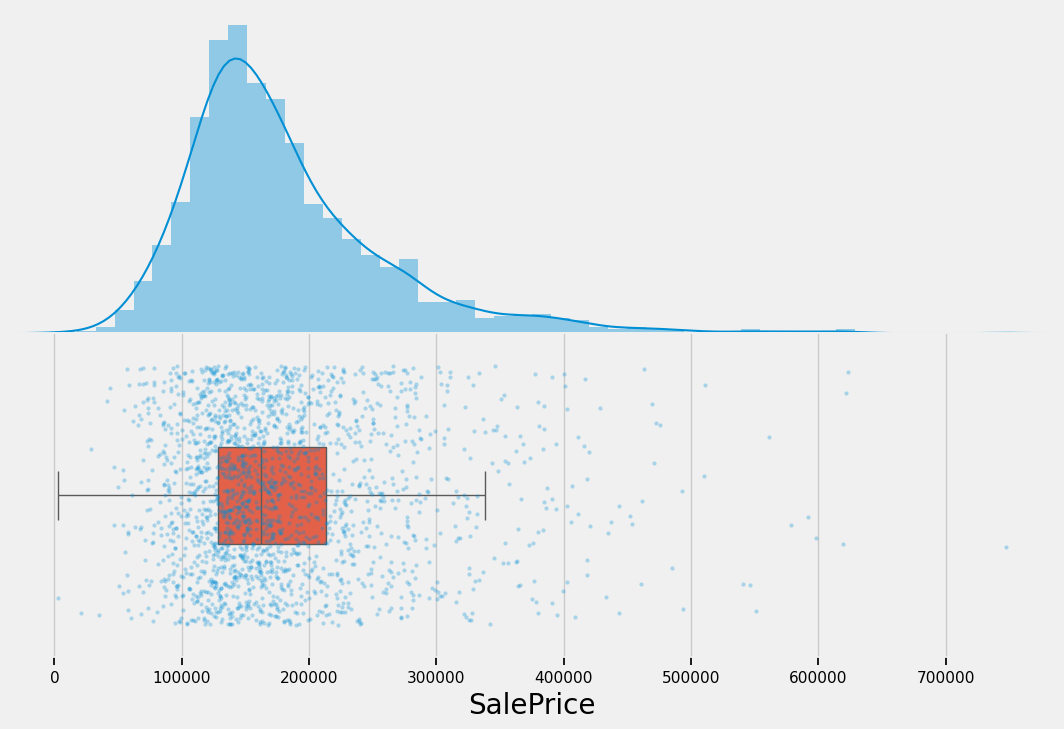

In [33]:
fig, axs = plt.subplots(figsize=(12, 8), nrows=2)

sns.distplot(
    ames_data['SalePrice'].values, 
    ax=axs[0]
)
sns.stripplot(
    ames_data['SalePrice'].values, 
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3,
    orient='h'
)
sns.boxplot(
    x=ames_data['SalePrice'].values,
    width=0.3, 
    ax=axs[1],
    showfliers=False,
    orient='h'
)

# Align axes
spacer = np.max(ames_data['SalePrice']) * 0.05
xmin = np.min(ames_data['SalePrice']) - spacer
xmax = np.max(ames_data['SalePrice']) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)
axs[1].set_xlabel('SalePrice', fontsize=20)

# Put the two plots together
plt.subplots_adjust(hspace=0)

Now, let's use the Pandas `describe()` method to look at some descriptive statistics of this variable.

In [35]:
ames_data['SalePrice'].describe()

count      2000.000000
mean     180775.897500
std       81581.671741
min        2489.000000
25%      128600.000000
50%      162000.000000
75%      213125.000000
max      747800.000000
Name: SalePrice, dtype: float64

## Question 1a
To check your understanding of the graph and summary statistics above, answer the following True or False questions:

1. The distribution of SalePrice in the training set is left-skewed.
2. The mean of SalePrice is greater than the median.
3. At least 25% of the houses in the training set sold for more than $200,000.00.

In [37]:
# Write your code here.
q1a_1 = ames_data['SalePrice'].mean() < ames_data['SalePrice'].median() 
q1a_2 = ames_data['SalePrice'].mean() > ames_data['SalePrice'].median()
q1a_3 = ((ames_data['SalePrice']>200000).sum() * 100 / len(ames_data)) > 25

print(q1a_1)
print(q1a_2)
print(q1a_3)

False
True
True


## SalePrice vs Gr_Liv_Area
Next, we visualize the association between `SalePrice` and `Gr_Liv_Area`. The `codebook.txt` file tells us that `Gr_Liv_Area` measures "above grade (ground) living area square feet."

This variable represents the square footage of the house excluding anything underground. Some additional research (into real estate conventions) reveals that this value also excludes the garage space.

## Question 1b
Create a cross-plot with `SalePrice` on the y-axis and `Gr_Liv_Area` on the x-axis. Use the Seaborn ploting function `sns.jointplot()`. You plot should look something like this.

<br>
<img src="images/join_plot_sales_gr_liv_area.png" alt="drawing" width="400"/>
<br>

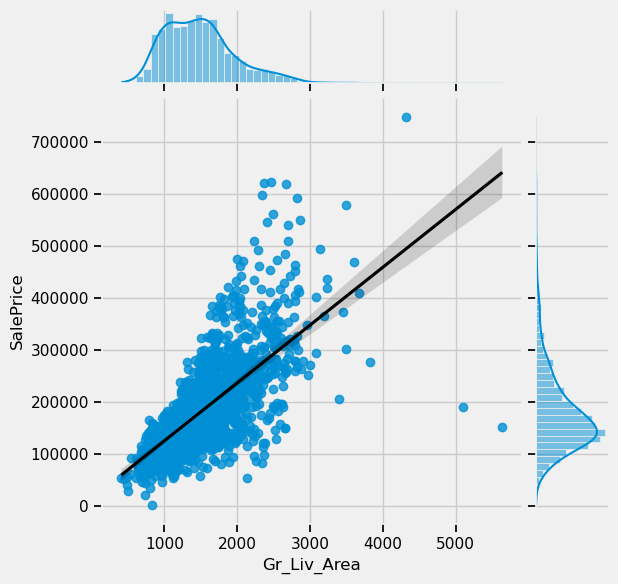

In [39]:
# A jointplot is created to compare Gr_Liv_Area to the SalePrice
graph=sns.jointplot(x=ames_data["Gr_Liv_Area"], y=ames_data["SalePrice"],
                kind="reg", joint_kws={'line_kws':{'color':'black'}})

There's certainly an association between `SalePrice` and `Gr_Liv_Area`, and perhaps it's linear, but the spread is wider at larger values of both variables. Also, there seems to be at least one suspicious houses above 5000 square feet that look too inexpensive for its size.

## Question 1c
Find the Parcel Indentification any houses with `Gr_Liv_Area` greater than 5000 sqft. Create a new variable called `potential_outliers` and assign a list of `PID`'s to it.

In [41]:
# The potential outliers are checked where "Gr_Liv_Area" exceeds 5000
potential_outliers = ames_data[ames_data["Gr_Liv_Area"]>5000]['PID'].tolist()

# Print answer
print("Potential outlier PID's: {}".format(potential_outliers))

Potential outlier PID's: [908154235, 908154195]


We've looked into these two homes in more detail and have determined that they are true outliers in this data set. They were partial sales, priced far below market value. Therefore, we would like to exlude them from our analysis.

## Question 1d
We could simply filter out these outliers using `Pandas` filtering functionality, but when doing machine learning, its always advantageous to create modular, reusable code. For example, we may want to remove outliers from other features and we may want to operationalize our code as a resuable pipeline.

Create a function `remove_outliers`, which removes outliers from a data set based off a `lower` and `upper` limit (non-inclusive). For example, `remove_outliers(training_data, 'Gr_Liv_Area', upper=5000)` should return a DataFrame with only observations that satisfy `Gr_Liv_Area` less than 5000.

In [43]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than this will be removed
      upper (numeric): observations with values higher than this will be removed
    
    Output:
      a winsorized data frame with outliers removed
    """
        
    winsorized_df = data[(data[variable]<upper) & (data[variable]>lower)]

    return winsorized_df

# Now, apply your function to remove any outliers
ames_data = remove_outliers(ames_data, 'Gr_Liv_Area', upper=5000)

# View DataFrame
ames_data.head()

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,204900
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,95300
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,181900
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,254100
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,199700


We started with 2000 rows in `ames_data`. A quick check.

In [45]:
ames_data.shape[0]

1998

Makes sense!

# 2. Feature Engineering
In this section we will create a new feature out of existing ones through a simple data transformation.

## Bathrooms
Let's create a new feature, which described the total number of bathrooms. We will use the following formula:

$$ \text{TotalBathrooms}=(\text{BsmtFullBath} + \text{FullBath}) + \dfrac{1}{2}(\text{BsmtHalfBath} + \text{HalfBath})$$

## Question 2a
Write a function `add_total_bathrooms(data)` that returns a copy of `data` with an additional column called `total_bathrooms` computed by the formula above. You should treat missing values as zeros. 

In [47]:
def add_total_bathrooms(data):
    """
    Input:
      data (data frame): a DataFrane containing at least 4 numeric columns 
            Bsmt_Full_Bath, Full_Bath, Bsmt_Half_Bath, and Half_Bath
    """
    
  # Make a copy of data
    with_bathrooms = data.copy()
    
    # fillna is used to replace missing values with 0.
    # a formaula to find the total number of bathrooms from existing columns.
    
    with_bathrooms[['Bsmt_Full_Bath', 'Full_Bath', 'Bsmt_Half_Bath', 'Half_Bath']] = with_bathrooms[['Bsmt_Full_Bath', 'Full_Bath', 'Bsmt_Half_Bath', 'Half_Bath']].fillna(0)
    
    with_bathrooms['total_bathrooms']=with_bathrooms['Bsmt_Full_Bath'] + with_bathrooms['Full_Bath'] + 0.5*(with_bathrooms['Bsmt_Half_Bath']+with_bathrooms['Half_Bath'])
    
    return with_bathrooms

# Now we can add the new feature
ames_data_with_bathrooms = add_total_bathrooms(ames_data)

# View DataFrame
ames_data_with_bathrooms.head()

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice,total_bathrooms
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,5,2010,WD,Normal,204900,2.0
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,NaN,MnPrv,NaN,0,6,2010,WD,Normal,95300,1.0
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,NaN,NaN,Gar2,12500,6,2010,WD,Normal,181900,1.5
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,NaN,NaN,NaN,0,4,2010,WD,Normal,254100,3.5
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,NaN,MnPrv,NaN,0,3,2010,WD,Normal,199700,2.5


Let's check out answer.

In [49]:
# Change row_id to check multiple rows
row_id = 2
print('Bsmt_Full_Bath: {}'.format(ames_data_with_bathrooms.loc[row_id , 'Bsmt_Full_Bath']))
print('Full_Bath: {}'.format(ames_data_with_bathrooms.loc[row_id , 'Full_Bath']))
print('Bsmt_Half_Bath: {}'.format(ames_data_with_bathrooms.loc[row_id , 'Bsmt_Half_Bath']))
print('Half_Bath: {}'.format(ames_data_with_bathrooms.loc[row_id , 'Half_Bath']))
print('total_bathrooms: {}'.format(ames_data_with_bathrooms.loc[row_id , 'total_bathrooms']))

Bsmt_Full_Bath: 0.0
Full_Bath: 1
Bsmt_Half_Bath: 0.0
Half_Bath: 1
total_bathrooms: 1.5


## Question 2b
Create a visualization that clearly shows that `total_bathrooms` is associated with `SalePrice`. Your visualization should avoid overplotting.

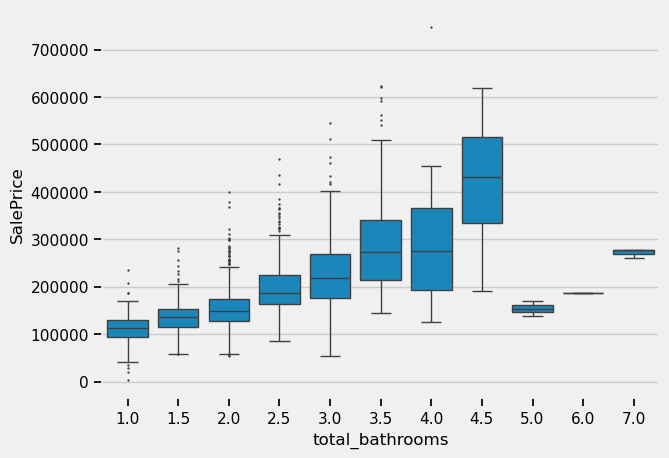

In [51]:
# A box plot is used to represent the spread of sale price for total bathrooms. To avoid 
# overplotting smaller marker sizes are used (0.7)
ax = sns.boxplot(
    x=ames_data_with_bathrooms["total_bathrooms"],
    y=ames_data_with_bathrooms["SalePrice"],
    fliersize=0.7
)

# 3. Modelling
We've reached the point where we can specify a model. But first, we will load a fresh copy of the data, just in case our code above produced any undesired side-effects. 

Run the cell below to store a fresh copy of the data from ames_train.csv in a dataframe named full_data. We will also store the number of rows in full_data in the variable full_data_len.

In [53]:
# Load a fresh copy of the data and get its length
full_data = pd.read_csv('ames_data.csv')
full_data_len = len(full_data)
full_data.head()

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,204900
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,95300
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,181900
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,254100
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,199700


## Question 3a
Now, let's split the data set into a training set, a validation set, and a test set. We will use the training set to fit our model's parameters, and we will use the validation set to estimate how well our model will perform on unseen data drawn from the same distribution. If we used all the data to fit our model, we would not have a way to estimate model performance on unseen data. The test set is used as a final unseen dataset and we shouldn't touch our test set until our model is finalized.

In the cell below, split the data in full_data into three DataFrames named `train`, `val`, and `test`. Let `train` contain 70% of the data, let `val` contain 15% of the data, and let `test` contain 15% of the data.

Use the `train_test_split()` function from `sklearn.model_selection` to perform these splits. Use a `random_state=0` as an argument to `train_test_split()`.

In [55]:
from sklearn.model_selection import train_test_split

# Train_test_split is used to split full_data into two datasets (train and test) and train
# is then split again to get the val datset

train, test = train_test_split(full_data, test_size = 0.15, random_state=0)
train, val = train_test_split(train, test_size = 0.176, random_state=0)

# Print results
print('Train {}%'.format(train.shape[0] / full_data.shape[0] * 100))
print('Val {}%'.format(val.shape[0] / full_data.shape[0] * 100))
print('Test {}%'.format(test.shape[0] / full_data.shape[0] * 100))

Train 70.0%
Val 15.0%
Test 15.0%


Lock the test set away and do not predict on it until you've selected your final model.

## Reusable Pipeline
Throughout this assignment, you should notice that your data flows through a single processing pipeline several times. From a software engineering perspective, it's best to define functions/methods that can apply the pipeline to any dataset. We will now encapsulate our entire pipeline into a single function `process_data`. We select a handful of features to use from the many that are available.

In [57]:
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def process_data(data):
    """Process the data for a guided model."""
    data = remove_outliers(data, 'Gr_Liv_Area', upper=5000)
    
    # Transform Data, Select Features
    data = add_total_bathrooms(data)
    data = select_columns(data, 
                          'SalePrice', 
                          'Gr_Liv_Area', 
                          'Garage_Area',
                          'total_bathrooms')
    
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']
    
    return X, y

Now, we can use `process_data` to clean our data, select features, and add our `TotalBathrooms` feature all in one step. This function also splits our data into `X`, a matrix of features, and `y`, a vector of sale prices (our training target). 

Run the cell below to feed our training and validation data through the pipeline, generating `X_train`, `y_train`, `X_val`, and `y_val`.

In [59]:
X_train, y_train = process_data(train)
X_val, y_val = process_data(val)

## Fitting Our First Model
We are finally going to fit a model.  The model we will fit can be written as follows:

$$\text{SalePrice} = \theta_0 + \theta_1 \cdot \text{Gr}\_\text{Liv}\_\text{Area} + \theta_2 \cdot \text{Garage}\_\text{Area} + \theta_3 \cdot \text{total_bathrooms}$$

**Note:** Notice that all of our variables are continuous, except for `total_bathrooms`, which takes on discrete ordered values (0, 0.5, 1, 1.5, ...). We'll treat `total_bathrooms` as a continuous quantitative variable in our model for now, but this might not be the best choice. The latter half of this assignment may revisit the issue.

## Question 3b
We will use a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object as our linear model. In the cell below, create a `LinearRegression` object and name it `linear_model`.

**Hint:** See the `fit_intercept` parameter and make sure it is set appropriately. The intercept of our model corresponds to $\theta_0$ in the equation above.

In [61]:
from sklearn.linear_model import LinearRegression

# LinearRegression is used to define the linear model
linear_model = LinearRegression(fit_intercept = True)

## Question 3c
Now, remove the commenting and fill in the ellipses `...` below with `X_train`, `y_train`, `X_val,` or `y_val`.

With the ellipses filled in correctly, the code below should fit our linear model to the training data and generate the predicted sale prices for both the training and validation datasets.

Assign your predictions for the training set to `y_fitted` and your predictions to the validation set to `y_predicted`.

In [63]:
# Uncomment the lines below and fill in 
# the ... with X_train, y_train, X_test, or y_test.
linear_model.fit(X_train, y_train)
y_fitted = linear_model.predict(X_train)
y_predicted = linear_model.predict(X_val)

## Question 3d
Is our linear model any good at predicting house prices? Let's measure the quality of our model by calculating the Root-Mean-Square Error (RMSE) between our predicted house prices and the true prices stored in `SalePrice`.

$$\text{RMSE} = \sqrt{\dfrac{\sum_{\text{houses in dataset}}(\text{actual price of house} - \text{predicted price of house})^2}{\text{number of houses in dataset}}}$$

In the cell below, write a function named `rmse` that calculates the RMSE of a model.

**Hint:** Make sure to vectorize your code. This question can be answered without any `for` statements.

In [65]:
def rmse(actual, predicted):
    """
    Calculates RMSE from actual and predicted values
    Input:
      actual (1D array): vector of actual values
      predicted (1D array): vector of predicted/fitted values
    Output:
      a float, the root-mean square error
    """
    N = actual.shape[0]
    diff = actual - predicted
    RMSE = np.sqrt((diff**2).sum() / N)
    
    return RMSE

## Question 3e
Now use your `rmse` function to calculate the training error and validation error in the cell below.

In [67]:
# the error is found for both the training dataset and the validation dataset
training_error = rmse(y_train, y_fitted)
val_error = rmse(y_val, y_predicted)

# Print answers
print('Training RMSE: ${}'.format(training_error))
print('Validation RMSE: ${}'.format(val_error))

Training RMSE: $45678.57486532342
Validation RMSE: $47051.14420041325


## Question 3f
How much does including `total_bathrooms` as a predictor reduce the RMSE of the model on the validation set? That is, what's the difference between the RSME of a model that only includes `Gr_Liv_Area` and `Garage_Area` versus one that includes all three predictors (`Gr_Liv_Area`, `Garage_Area`, and `total_bathrooms`)?

In [69]:
# Drop 'total_bathrooms'
X_train_no_bath = X_train.drop('total_bathrooms', axis=1)
X_val_no_bath = X_val.drop('total_bathrooms', axis=1)

# Initialize model
linear_model_no_bath = LinearRegression(fit_intercept=True)

# Fit model
linear_model_no_bath.fit(X_train_no_bath, y_train)
y_predicted_no_bath = linear_model_no_bath.predict(X_val_no_bath)

# Compute training and validation errors
val_error_no_bath = rmse(y_val,y_predicted_no_bath)

# compute error difference
val_error_difference = abs(val_error - val_error_no_bath)

# Print results
print('Validation RMSE: ${}'.format(val_error))
print('Validation RMSE (No Bath): ${}'.format(val_error_no_bath))
print('Validation Error Difference: {}'.format(val_error_difference))

Validation RMSE: $47051.14420041325
Validation RMSE (No Bath): $49674.11452928875
Validation Error Difference: 2622.9703288755045


## Residual Plots
One way of understanding the performance (and appropriateness) of a model is through a residual plot. Run the cell below to plot the actual sale prices against the residuals of the model for the validation data.

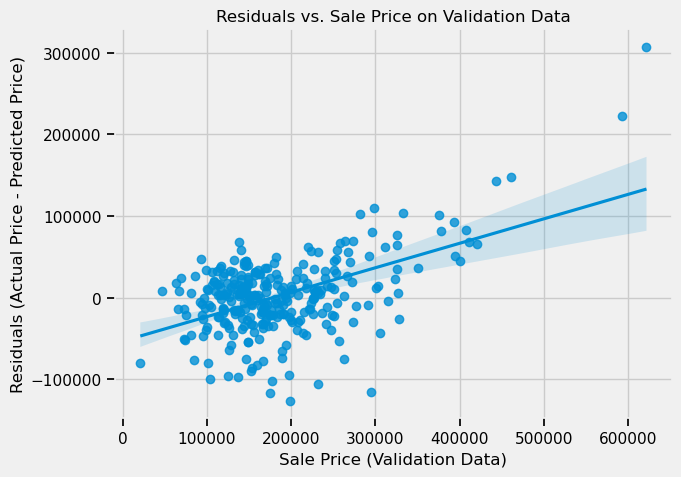

In [71]:
residuals = y_val - y_predicted
ax = sns.regplot(x=y_val, y=residuals)
ax.set_xlabel('Sale Price (Validation Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')
ax.set_title("Residuals vs. Sale Price on Validation Data");

Ideally, we would see a horizontal line of points at 0 (a perfect prediction!). The next best thing would be a homogenous set of points centered at 0.

But alas, our simple model is probably too simple. The most expensive homes are systematically more expensive than our prediction.

## Question 3g
What changes could you make to your linear model to improve its accuracy and lower the validation error? Suggest at least two things you could try in the cell below, and carefully explain how each change could potentially improve your model's accuracy.

More features can be added to the model, as right now it is dependent on one variable (the bathroom size) and more data will result in better predictions. In addition, more outlier data can be identified from the dataset and removed.

# 4. Cross Validation
Moving forward, we will now use cross validation to help validate our model instead of explicitly splitting the data into a training and validation set. To do this, we'll need to create a cross-validation function for our `rmse` score.

First, let's split the `full_data` again but this time into only two datasets `train` and `test`. Let `train` contain 70% of the data, let `test` contain 30% of the data.

Again, we will use the `train_test_split()` function from `sklearn.model_selection` to perform these splits and use a `random_state=0` as an argument to `train_test_split()`.

In [73]:
# Split dataset
train, test = train_test_split(full_data, test_size=0.30, random_state=0)

# Print results
print('Train {}%'.format(train.shape[0] / full_data.shape[0] * 100))
print('Test {}%'.format(test.shape[0] / full_data.shape[0] * 100))

Train 70.0%
Test 30.0%


Next, let's use out `process_data` function to get our features (`X_train`) and target ('y_train') for the training dataset.

In [75]:
X_train, y_train = process_data(train)

# Question 4
Create a cross-validation function, which returns the average `rmse` score from all 5 splits.

Hint: `train_index` and `val_index` contain the train and val row indices for `X` and `y`.

In [77]:
from sklearn.model_selection import KFold
from sklearn.base import clone

def cross_validate_rmse(model, X, y):
    
    # Setup
    model = clone(model)
    five_fold = KFold(n_splits=5)
    rmse_values = []
    
    # Iterature through cv-folds
    for train_index, val_index in five_fold.split(X):
        
        #the train_index and val_index are used to define the X and Y training 
        #and validation values
        split_X_train, split_X_valid = X.iloc[train_index], X.iloc[val_index]
        split_Y_train, split_Y_valid = y.iloc[train_index], y.iloc[val_index]

        # Fit the model on the training split
        model.fit(split_X_train,split_Y_train)
        
        # Compute the RMSE on the validation split
        y_predicted = model.predict(split_X_valid)
        
        # The RMSE error is computed, comparing the Y validation values to Y predicted 
        # values from the model
        error = rmse(split_Y_valid, y_predicted)
        
        rmse_values.append(error)
        
    return rmse_values

Now, let's apply out new cross-validation function to out training dataset.

In [79]:
cv_scores = cross_validate_rmse(model=LinearRegression(fit_intercept=True), X=X_train, y=y_train)

# Print cv scores
print('Cross-validation RMSE scores: {}'.format(cv_scores))
print('Cross-validation RMSE scores mean: ${}'.format(np.mean(cv_scores)))
print('Cross-validation RMSE scores std: ${}'.format(np.std(cv_scores)))

Cross-validation RMSE scores: [53256.63312984414, 40632.040286195836, 40982.685175624334, 43732.46059794499, 42570.166436669446]
Cross-validation RMSE scores mean: $44234.79712525575
Cross-validation RMSE scores std: $4646.99798115019


Next, let's compare this to our old validation score from earlier.

In [81]:
print('Validation RMSE score: ${}'.format(val_error))
print('Cross-validation RMSE scores mean: ${}'.format(np.mean(cv_scores)))

Validation RMSE score: $47051.14420041325
Cross-validation RMSE scores mean: $44234.79712525575


This example clearly demonstrates the function of cross-validation instead of explicitly splitting the data into a training and validation set. 

We can see that the first cross-validation score for the first split is `53256.63312984414`, which is similar to our original validation score. However, the other 4 cross-validation scores are lower (`40632.040286195836, 40982.685175624334, 43732.46059794499, 42570.16643666945`). 

Especially when datasets are small, sampling bias can cause differences in performance depending on how a dataset is split. Cross-validation ensures you're able to monitor this variability and evaluate your models properly.

# 5. More Feature Selection and Engineering 
The linear model that you created failed to produce accurate estimates of the observed housing prices because the model was too simple. The goal of the next few sections is to guide you through the iterative process of specifying, fitting, and analyzing the performance of more complex linear models used to predict prices of houses in Ames, Iowa. 

In this section, we identify two more features of the dataset that will increase our linear regression model's accuracy. Additionally, we will implement one-hot encoding so that we can include binary and categorical variables in our improved model.

We've used a slightly modified data cleaning pipeline from the first half of the assignment to prepare the data. This data is stored in `ames_data_cleaned.csv`. It consists of 1998 observations and 83 features (we added the feature `total_bathrooms` from the first half of the assignment).

First, let's import `ames_data_cleaned.csv`.

In [83]:
ames_data_cleaned = pd.read_csv('ames_data_cleaned.csv')
ames_data_cleaned.head()

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice,total_bathrooms
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,5,2010,WD,Normal,204900,2.0
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,NaN,MnPrv,NaN,0,6,2010,WD,Normal,95300,1.0
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,NaN,NaN,Gar2,12500,6,2010,WD,Normal,181900,1.5
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,NaN,NaN,NaN,0,4,2010,WD,Normal,254100,3.5
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,NaN,MnPrv,NaN,0,3,2010,WD,Normal,199700,2.5


Next, let's split the `ames_data_cleaned` into only two datasets `train` and `test`. Let `train` contain 70% of the data, let `test` contain 30% of the data.

Again, we will use the `train_test_split()` function from `sklearn.model_selection` to perform these splits and use a `random_state=0` as an argument to `train_test_split()`.

In [85]:
# Split dataset
train_cleaned, test_cleaned = train_test_split(ames_data_cleaned, test_size=0.30, random_state=0)

# Print results
print('Train {}%'.format(train_cleaned.shape[0] / ames_data_cleaned.shape[0] * 100))
print('Test {}%'.format(test_cleaned.shape[0] / ames_data_cleaned.shape[0] * 100))

Train 69.96996996996997%
Test 30.03003003003003%


## Neighborhood vs Sale Price
First, let's take a look at the relationship between neighborhood and sale prices of the houses in our data set.

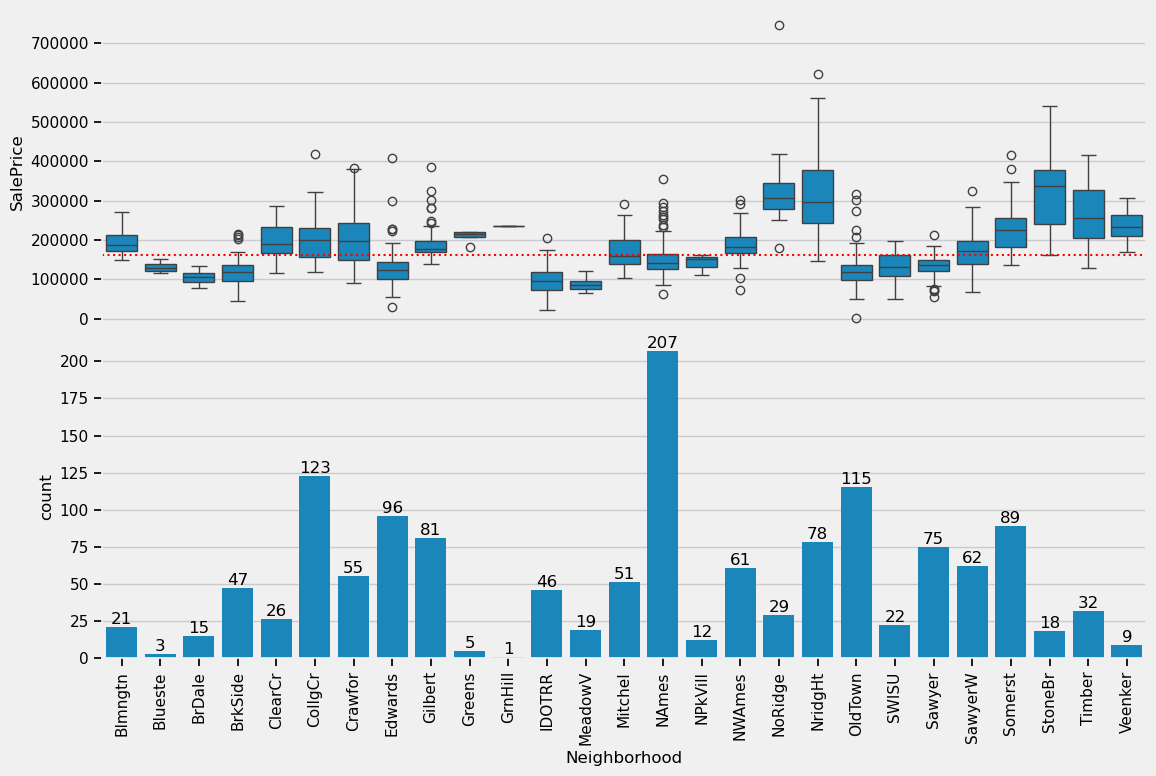

In [87]:
fig, axs = plt.subplots(nrows=2, figsize=(12, 8))

sns.boxplot(
    x='Neighborhood',
    y='SalePrice',
    data=train_cleaned.sort_values('Neighborhood'),
    ax=axs[0]
)

sns.countplot(
    x='Neighborhood',
    data=train_cleaned.sort_values('Neighborhood'),
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y=train_cleaned['SalePrice'].median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.01)

## Question 5a
Based on the plot above, what can be said about the relationship between the house sale prices and their neighborhoods?

Generally there is not too much spread in a given neighbourhood for the house prices, from the box-plot. This indicates that generally homes are priced similarly in neighbourhoods, where more expensive homes will be in the more expensive neighbourhoods and similarly for less-expensive homes.

## Question 5b
One way we can deal with the lack of data from some neighborhoods is to create a new feature that bins neighborhoods together.  Let's categorize our neighborhoods in a crude way. Take the top 3 neighborhoods measured by median `SalePrice` and identify them as **"rich neighborhoods"**. We won't mark the other neighborhoods.

Write a function that returns a list of the top `n` most pricy neighborhoods as measured by our choice of aggregating function (`np.median, np.mean, etc.`).  For example, in the setup above, we would want to call `find_rich_neighborhoods(train_cleaned, 3, np.median)` to find the top 3 neighborhoods measured by median `SalePrice`.

In [89]:
def find_rich_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (data frame): should contain at least a string-valued Neighborhood
        and a numeric SalePrice column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the top n richest neighborhoods as measured by the metric function
    """
    
   #groupby is used to aggregate the data by neighborhood and the aggregation is completed
    #using sale price. The n largest homes are kept using nlargest method.
    neighborhoods = data.groupby('Neighborhood').agg({'SalePrice': metric})
    neighborhoods = neighborhoods['SalePrice'].nlargest(n)
    
    return neighborhoods

# Find rich neighborhoodsv
rich_neighborhoods = find_rich_neighborhoods(train_cleaned, 3, np.median)

# Print rich neighborhoods
print('The three richest neighborhoods are: {}'.format(rich_neighborhoods))

The three richest neighborhoods are: Neighborhood
StoneBr    336532.5
NoRidge    307400.0
NridgHt    297500.0
Name: SalePrice, dtype: float64


Check the figure above to make sure you've got the correct answer.

## Question 5c
We now have a list of neighborhoods we've deemed as richer than others.  Let's use that information to make a new variable `in_rich_neighborhood`.  Write a function `add_rich_neighborhood` that adds an indicator variable which takes on the value 1 if the house is part of `rich_neighborhoods` and the value 0 otherwise.

**Hint:** [`pd.Series.astype`](https://pandas.pydata.org/pandas-docs/version/0.23.4/generated/pandas.Series.astype.html) may be useful for converting True/False values to integers.

In [91]:
def add_in_rich_neighborhood(data, neighborhoods):
    """
    Input:
      data (data frame): a data frame containing a 'Neighborhood' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as rich
    Output:
      data frame identical to the input with the addition of a binary
      in_rich_neighborhood column
    """
    data_copy = data.copy()
    
   # data_copy neighborhood values are compared for membership in neighborhoods 
    #dataframe using isin function
    data_copy['in_rich_neighborhood'] = data_copy.Neighborhood.isin(neighborhoods.index).astype(int)
    
    return data_copy

# Add 'in_rich_neighborhood' feature
train_cleaned_rich = add_in_rich_neighborhood(train_cleaned, 
                                              rich_neighborhoods)

# View DataFrame
train_cleaned_rich.head()

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice,total_bathrooms,in_rich_neighborhood
1700,2512,533223010,160,FV,35.0,3735,Pave,NaN,Reg,Lvl,...,NaN,NaN,0,3,2006,WD,Normal,177800,3.5,0
638,946,912251110,30,I (all),109.0,21780,Grvl,NaN,Reg,Lvl,...,NaN,NaN,0,3,2009,ConLD,Normal,66525,1.0,0
482,697,902105050,50,RM,90.0,15660,Pave,NaN,Reg,Lvl,...,MnPrv,NaN,0,7,2009,WD,Normal,120900,1.5,0
616,913,909251050,30,RL,64.0,8574,Pave,NaN,Reg,Lvl,...,NaN,NaN,0,10,2009,WD,Normal,138600,1.0,0
372,538,531369020,20,RL,76.0,10141,Pave,NaN,IR1,Lvl,...,NaN,NaN,0,1,2009,WD,Normal,194100,2.0,0


Let's check to see if our function added the new feature correctly. We should see a value of 1 for this rich neighborhood.

In [93]:
train_cleaned_rich[train_cleaned_rich['Neighborhood'] == 'NoRidge'].head()

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice,total_bathrooms,in_rich_neighborhood
68,91,533130020,60,RL,107.0,10186,Pave,NaN,IR1,Lvl,...,NaN,NaN,0,6,2010,WD,Normal,179800,3.5,1
354,505,528390100,60,RL,52.0,46589,Pave,NaN,IR2,Lvl,...,NaN,NaN,0,7,2009,WD,Normal,411200,3.5,1
1192,1768,528351010,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,...,NaN,NaN,0,1,2007,WD,Normal,747800,4.0,1
776,1158,533125080,60,RL,NaN,9205,Pave,NaN,IR1,Lvl,...,NaN,NaN,0,6,2008,WD,Normal,282200,3.5,1
49,64,528382020,60,RL,92.0,11764,Pave,NaN,IR1,Lvl,...,NaN,NaN,0,4,2010,WD,Normal,279900,2.5,1


## Fireplace Quality
In the following section, we will take a closer look at the Fireplace_Qu feature of the dataset and examine how we can incorporate categorical features into our linear model.

## Question 5d
Let's see if our data set has any missing values.  Create a Series object containing the counts of missing values in each of the columns of our data set, sorted from greatest to least.  The Series should be indexed by the variable names.  For example, `missing_counts.loc['Fireplace_Qu']` should return 688.

**Hint:** [`pandas.DataFrame.isnull()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isnull.html) may help here.

In [137]:
# the counts of null values are checked in the dataframe
missing_counts = train_cleaned_rich.isnull().sum().sort_values(ascending=False)

# Display missing_counts
missing_counts
#missing_counts.loc['Fireplace_Qu']

Pool_QC                 1395
Misc_Feature            1352
Alley                   1308
Fence                   1140
Mas_Vnr_Type             851
                        ... 
PID                        0
1st_Flr_SF                 0
2nd_Flr_SF                 0
Low_Qual_Fin_SF            0
in_rich_neighborhood       0
Length: 84, dtype: int64

## Question 5e
An `NA` here actually means that the house had no fireplace to rate.  Let's fix this in our data set.  Write a function that replaces the missing values in `Fireplace_Qu` with `'No Fireplace'`.  In addition, it should replace each abbreviated condition with its full word.  For example, `'TA'` should be changed to `'Average'`, `'FA'` should be changed to `'Fair'`, and so on.  Hint: the [`DataFrame.replace()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.replace.html) method may be useful here.

In [97]:
def fix_fireplace_qu(data):
    """
    Input:
      data (data frame): a data frame containing a Fireplace_Qu column.  Its values
                         should be limited to those found in the codebook
    Output:
      data frame identical to the input except with a refactored Fireplace_Qu column
    """
    #a dictionary is defined with all fireplace abbreviations
    abbreviations = {
       "Ex": "Excellent",
       "Gd": "Good",
       "TA": "Average",
       "Fa": "Fair",
       "Po": "Poor",
       np.nan:"No Fireplace"
    }
    
    #replace is used to remove values in column Fireplace_Qu
    data['Fireplace_Qu'] = data['Fireplace_Qu'].replace(abbreviations)
    
    return data
   
# Correct Fireplace_Qu
training_data_fireplace_qu = fix_fireplace_qu(train_cleaned_rich)

# View DataFrame
training_data_fireplace_qu.head()

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice,total_bathrooms,in_rich_neighborhood
1700,2512,533223010,160,FV,35.0,3735,Pave,NaN,Reg,Lvl,...,NaN,NaN,0,3,2006,WD,Normal,177800,3.5,0
638,946,912251110,30,I (all),109.0,21780,Grvl,NaN,Reg,Lvl,...,NaN,NaN,0,3,2009,ConLD,Normal,66525,1.0,0
482,697,902105050,50,RM,90.0,15660,Pave,NaN,Reg,Lvl,...,MnPrv,NaN,0,7,2009,WD,Normal,120900,1.5,0
616,913,909251050,30,RL,64.0,8574,Pave,NaN,Reg,Lvl,...,NaN,NaN,0,10,2009,WD,Normal,138600,1.0,0
372,538,531369020,20,RL,76.0,10141,Pave,NaN,IR1,Lvl,...,NaN,NaN,0,1,2009,WD,Normal,194100,2.0,0


Let's check out the unique values in `Fireplace_Qu` now.

In [99]:
training_data_fireplace_qu['Fireplace_Qu'].unique().tolist()

['No Fireplace', 'Good', 'Fair', 'Average', 'Excellent', 'Poor']

### Using Categorical Variables for Regression
Unfortunately, simply fixing these missing values isn't sufficient for using `Fireplace_Qu` in our model.  Since `Fireplace_Qu` is a categorical variable, we will have to **dummy-encode** the data. Note that dummy-encoding drops the first one-hot-encoded column. For more information on categorical data in pandas, refer to this [link](https://pandas-docs.github.io/pandas-docs-travis/categorical.html).

In [101]:
def ohe_fireplace_qu(data):
    """
    One-hot-encodes fireplace quality.  '
    New columns are of the form Fireplace_Qu_QUALITY
    """
    # List categories
    categories = ['Excellent',
                  'Good',
                  'Average',
                  'Fair',
                  'Poor',
                  'No Fireplace']

    category_type = pd.CategoricalDtype(categories=categories)
    data.loc[:, 'Fireplace_Qu'] = data.loc[:, 'Fireplace_Qu'].astype(category_type)
    data = pd.get_dummies(data, 
                          prefix='Fireplace_Qu',
                          columns=['Fireplace_Qu'], 
                          drop_first=True)
    
    return data

# Encode 'Fireplace_Qu'
training_data_ohe = ohe_fireplace_qu(training_data_fireplace_qu)

# View new encoded features
training_data_ohe[[col for col in training_data_ohe.columns 
                   if 'Fireplace_Qu' in col]].head()

,Fireplace_Qu_Excellent,Fireplace_Qu_Fair,Fireplace_Qu_Good,Fireplace_Qu_No Fireplace,Fireplace_Qu_Poor
1700,False,False,False,True,False
638,False,False,False,True,False
482,False,False,False,True,False
616,False,False,True,False,False
372,False,False,False,True,False


Notice that there are five new binary features:
- `'Fireplace_Qu_Good'`
- `'Fireplace_Qu_Average'`
- `'Fireplace_Qu_Fair'`
- `'Fireplace_Qu_Poor'`
- `'Fireplace_Qu_No Fireplace'`

but we initially had 6 categories. Where is `'Fireplace_Qu_Excellent'`?

Imagine a case where:
- `'Fireplace_Qu_Good'=0`
- `'Fireplace_Qu_Average'=0`
- `'Fireplace_Qu_Fair'=0`
- `'Fireplace_Qu_Poor'=0`
- `'Fireplace_Qu_No Fireplace'=0`

This this would mean that the Fireplace quality is excellent. If we added a sixth features named `'Fireplace_Qu_Excellent'`, then is would mean that our Fireplace features would be correlated and redundant.

Basically:
- `'Fireplace_Qu_Good'=0`
- `'Fireplace_Qu_Average'=0`
- `'Fireplace_Qu_Fair'=0`
- `'Fireplace_Qu_Poor'=0`
- `'Fireplace_Qu_No Fireplace'=0`

would mean the same thing as:
- `'Fireplace_Qu_Excellent'=1`

Therefore, it is desireable to dropped the first one-hot-encoded column, which we call dummy-encoding.

# 6. Improving Our Linear Model

In this section, we will create linear models that produce more accurate estimates of the housing prices in Ames compared to the model from the first half of this assignment. However, this improved accuracy comes at the expense of increased complexity.

The model we will fit can be written as follows:

$$
\text{SalePrice} = 
\theta_0 + 
\theta_1 \cdot \text{Gr\_Liv\_Area} + 
\theta_2 \cdot \text{Garage\_Area} + 
\theta_3 \cdot \text{total\_bathrooms} +
\theta_4 \cdot \text{in\_rich\_neighborhood} +
\theta_5 \cdot \text{(Fireplace\_Qu\_Good)} +
\theta_6 \cdot \text{(Fireplace\_Qu\_Average)} +
\theta_7 \cdot \text{(Fireplace\_Qu\_Fair)} +
\theta_8 \cdot \text{(Fireplace\_Qu\_Poor)} +
\theta_9 \cdot \text{(Fireplace\_Qu\_No\_Fireplace)}
$$

We still have a little bit of work to do before estimating our linear regression model's coefficients. Instead of having you manually select the pertinent features and create a [`sklearn.linear_model.LinearRegression()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object again, we will provide the necessary code from the first half of this assignment. However, we will now use cross-validation to validate our model, rather than explicitly splitting the data into a training and validation set.

First, we will re-import the data.

In [103]:
ames_data_cleaned = pd.read_csv('ames_data_cleaned.csv')
ames_data_cleaned.head()

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice,total_bathrooms
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,5,2010,WD,Normal,204900,2.0
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,NaN,MnPrv,NaN,0,6,2010,WD,Normal,95300,1.0
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,NaN,NaN,Gar2,12500,6,2010,WD,Normal,181900,1.5
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,NaN,NaN,NaN,0,4,2010,WD,Normal,254100,3.5
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,NaN,MnPrv,NaN,0,3,2010,WD,Normal,199700,2.5


And split into training and test data.

In [105]:
# Split dataset
train_cleaned, test_cleaned = train_test_split(ames_data_cleaned, test_size=0.30, random_state=0)

# Print results
print('Train {}%'.format(train_cleaned.shape[0] / ames_data_cleaned.shape[0] * 100))
print('Test {}%'.format(test_cleaned.shape[0] / ames_data_cleaned.shape[0] * 100))

Train 69.96996996996997%
Test 30.03003003003003%


Next, we will implement a reusable pipeline that selects the required variables in our data and splits our feature and target variable into a matrix and a vector, respectively.

In [107]:
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def process_data(data):
    """Process the data for a guided model."""
    # One-hot-encode fireplace quality feature
    data = fix_fireplace_qu(data)
    data = ohe_fireplace_qu(data)
    
    # Use rich_neighborhoods computed earlier to add in_rich_neighborhoods feature
    data = add_in_rich_neighborhood(data, rich_neighborhoods)
    
    # Transform Data, Select Features
    data = select_columns(data, 
                          'SalePrice', 
                          'Gr_Liv_Area', 
                          'Garage_Area',
                          'total_bathrooms',
                          'in_rich_neighborhood',
                          'Fireplace_Qu_Excellent',
                          'Fireplace_Qu_Good',
                          'Fireplace_Qu_Fair',
                          'Fireplace_Qu_Poor',
                          'Fireplace_Qu_No Fireplace')
    
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']
    
    return X, y

We then process our training set using our data cleaning pipeline.

In [109]:
# Pre-process the training data
# Our functions make this very easy!
X_train, y_train = process_data(train_cleaned)
X_train.head()

,Gr_Liv_Area,Garage_Area,total_bathrooms,in_rich_neighborhood,Fireplace_Qu_Excellent,Fireplace_Qu_Good,Fireplace_Qu_Fair,Fireplace_Qu_Poor,Fireplace_Qu_No Fireplace
1700,1452,506,3.5,0,False,False,False,False,True
638,810,280,1.0,0,False,False,False,False,True
482,1306,472,1.5,0,False,False,False,False,True
616,1232,440,1.0,0,False,True,False,False,False
372,1512,845,2.0,0,False,False,False,False,True


## Question 6a
Use the `cross_validate_rmse` function to calculate the cross validation error in the cell below.

In [113]:
# cross_validate_rmse is called to check the X_train and y_train data against the
# linear regression model with 9 features for X.
cv_scores_updated = cross_validate_rmse(model=LinearRegression(fit_intercept=True), X=X_train, y=y_train)

# Print cv scores
print('Cross-validation RMSE scores: {}'.format(cv_scores_updated))
print('Cross-validation RMSE scores mean: ${}'.format(np.mean(cv_scores_updated)))
print('Cross-validation RMSE scores std: ${}'.format(np.std(cv_scores_updated)))

Cross-validation RMSE scores: [47251.9927914117, 37945.83034595923, 35922.43286786433, 35519.95827557161, 38391.895655828805]
Cross-validation RMSE scores mean: $39006.42198732713
Cross-validation RMSE scores std: $4269.8560450996265


Let's compare this to our earlier cross-validation score when only using:
- `'SalePrice'`
- `'Gr_Liv_Area'` 
- `'Garage_Area'`
- `'total_bathrooms'`

In [115]:
print('Cross-validation RMSE scores mean: ${}'.format(np.mean(cv_scores)))

Cross-validation RMSE scores mean: $44234.79712525575


You've done it! by adding two new features, we've improved our model's performance.

Now that we are happy with out model's performance and have settled on a final set of features, we can train the final model on the entire training dataset. First, we initialize a `sklearn.linear_model.LinearRegression()` object as our linear model. We set the `fit_intercept=True` to ensure that the linear model has a non-zero intercept.

In [117]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression(fit_intercept=True)

It's finally time to fit our updated linear regression model. The cell below estimates the model and then uses it to compute the fitted value of `SalePrice` over the training data.

In [119]:
# Fit the model
linear_model.fit(X_train, y_train)

# Compute the fitted and predicted values of SalePrice
y_fitted = linear_model.predict(X_train)

Let's assess the performance of our new linear regression model using the Root Mean Squared Error function from earlier in this assignment.

In [121]:
training_error = rmse(y_fitted, y_train)
print("Training RMSE: ${}".format(training_error))

Training RMSE: $38680.59452922024


## Question 6b
Now that we have trained our final model, we can evaluate it on our test data. Prediced. Predict the house price for the test feature `X_test` and named the variable `y_predicted`. Then compute the test `RMSE`.

In [123]:
# Pre-process the training data
# Our functions make this very easy!
X_test, y_test = process_data(test_cleaned)
X_test.head()

# the model created is now tested against the test data (X_test and y_test)
y_predicted = linear_model.predict(X_test)
test_error = rmse(y_test, y_predicted)
print("Test RMSE: ${}".format(test_error))

Test RMSE: $43714.74513673109


# 7. Open-Response 
The following part is purposefully left nearly open-ended. 

## Question 7
Your goal is to provide a linear regression model that improves the cross-validation root mean square error from the previous section.

- Cross-validation RMSE scores mean: `$39006.42198732712`

To do this, you should add at least one new feature. Please use Markdown cells to explain your thinking when engineering new features.

Let's import the data and split again with new variable names for this section.

In [125]:
ames_data_cleaned_q7 = pd.read_csv('ames_data_cleaned.csv')
ames_data_cleaned_q7.head()

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,...,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice,total_bathrooms
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,NaN,NaN,NaN,0,5,2010,WD,Normal,204900,2.0
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,NaN,MnPrv,NaN,0,6,2010,WD,Normal,95300,1.0
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,NaN,NaN,Gar2,12500,6,2010,WD,Normal,181900,1.5
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,NaN,NaN,NaN,0,4,2010,WD,Normal,254100,3.5
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,NaN,MnPrv,NaN,0,3,2010,WD,Normal,199700,2.5


In [127]:
# Split dataset
train_cleaned_q7, test_cleaned_q7 = train_test_split(ames_data_cleaned_q7, test_size=0.30, random_state=0)

# Print results
print('Train {}%'.format(train_cleaned_q7.shape[0] / ames_data_cleaned_q7.shape[0] * 100))
print('Test {}%'.format(test_cleaned_q7.shape[0] / ames_data_cleaned_q7.shape[0] * 100))

Train 69.96996996996997%
Test 30.03003003003003%


Here is your resuable pipeline. You'll want to add a least one new feature here:

```python
data = select_columns(data, 
                      'SalePrice', 
                      'Gr_Liv_Area', 
                      'Garage_Area',
                      'total_bathrooms',
                      'in_rich_neighborhood',
                      'Fireplace_Qu_Excellent',
                      'Fireplace_Qu_Good',
                      'Fireplace_Qu_Fair',
                      'Fireplace_Qu_Poor',
                      'Fireplace_Qu_No Fireplace')
```

In [ ]:
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def process_data(data):
    """Process the data for a guided model."""
    # One-hot-encode fireplace quality feature
    data = fix_fireplace_qu(data)
    data = ohe_fireplace_qu(data)
    
    # Use rich_neighborhoods computed earlier to add in_rich_neighborhoods feature
    data = add_in_rich_neighborhood(data, rich_neighborhoods)
    
    # Transform Data, Select Features
    data = select_columns(data, 
                          'SalePrice', 
                          'Gr_Liv_Area', 
                          'Garage_Area',
                          'total_bathrooms',
                          'in_rich_neighborhood',
                          'Fireplace_Qu_Excellent',
                          'Fireplace_Qu_Good',
                          'Fireplace_Qu_Fair',
                          'Fireplace_Qu_Poor',
                          'Fireplace_Qu_No Fireplace')
    
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']
    
    return X, y

In [129]:
train_cleaned_q7, test_cleaned_q7 = train_test_split(ames_data_cleaned_q7, test_size=0.30, random_state=0)

# Print results
print('Train {}%'.format(train_cleaned_q7.shape[0] / ames_data_cleaned_q7.shape[0] * 100))
print('Test {}%'.format(test_cleaned_q7.shape[0] / ames_data_cleaned_q7.shape[0] * 100))

Train 69.96996996996997%
Test 30.03003003003003%


## Final Evaluation
This is where you can compute your cross-validation score. `X_train_q7` and `y_train_q7` should be your new feature and target variables. `X_train_q7` should include at least one new feature.

In [133]:
# Pre-process the training data
X_train_q7, y_train_q7 = process_data(train_cleaned)

# Write your code here.
cv_scores_updated = cross_validate_rmse(model=LinearRegression(fit_intercept=True), 
                                        X=X_train_q7, y=y_train_q7)

# Print cv scores
print('Cross-validation RMSE scores: {}'.format(cv_scores_updated))
print('Cross-validation RMSE scores mean: ${}'.format(np.mean(cv_scores_updated)))
print('Cross-validation RMSE scores std: ${}'.format(np.std(cv_scores_updated)))

Cross-validation RMSE scores: [47251.9927914117, 37945.83034595923, 35922.43286786433, 35519.95827557161, 38391.895655828805]
Cross-validation RMSE scores mean: $39006.42198732713
Cross-validation RMSE scores std: $4269.8560450996265
